In [1]:
import onnx 
import torch


In [2]:
import os
from qonnx.core.modelwrapper import ModelWrapper

model_dir = os.environ['FINN_ROOT'] + "/notebooks/end2end_example/cnn-dizeratie"
ready_model_filename = model_dir + "/drowsy-cnn-ready.onnx"

print("Model dir:", model_dir)
print("Ready model:", ready_model_filename)
print("File exists?", os.path.isfile(ready_model_filename))

model_for_sim = ModelWrapper(ready_model_filename)


Model dir: /home/stefan/finn/notebooks/end2end_example/cnn-dizeratie
Ready model: /home/stefan/finn/notebooks/end2end_example/cnn-dizeratie/drowsy-cnn-ready.onnx
File exists? True


In [3]:
from qonnx.transformation.general import (
    GiveUniqueNodeNames,
    RemoveStaticGraphInputs,
)
from finn.transformation.streamline import Streamline
from qonnx.transformation.infer_datatypes import InferDataTypes
from qonnx.transformation.infer_shapes import InferShapes

# Apply a standard sequence of tidy-up transformations
# (Skip GiveReadableTensorNames because it asserts on empty node names)
model_for_sim = model_for_sim.transform(GiveUniqueNodeNames())
model_for_sim = model_for_sim.transform(RemoveStaticGraphInputs())
model_for_sim = model_for_sim.transform(InferShapes())
model_for_sim = model_for_sim.transform(InferDataTypes())
model_for_sim = model_for_sim.transform(Streamline())

print("Transformed FINN-ONNX model is in memory (model_for_sim).")


Transformed FINN-ONNX model is in memory (model_for_sim).


In [4]:
import numpy as np

testset_npz_path = os.path.join(model_dir, "drowsy_cnn_testset.npz")
data = np.load(testset_npz_path)

# N, 3, 64, 64
input_np  = data["inputs"]
labels_np = data["labels"]

print("Loaded testset from:", testset_npz_path)
print("inputs shape:", input_np.shape)
print("labels shape:", labels_np.shape)

input_tensor  = torch.from_numpy(input_np).float()    # (N, 3, 64, 64)
labels_tensor = torch.from_numpy(labels_np).long()    # (N,)


Loaded testset from: /home/stefan/finn/notebooks/end2end_example/cnn-dizeratie/drowsy_cnn_testset.npz
inputs shape: (128, 3, 128, 128)
labels shape: (128,)


In [5]:
import torch.nn as nn
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

weight_bit_width = 2
act_bit_width    = 4
num_classes      = 2
input_height     = 128
input_width      = 128

torch.manual_seed(0)

class DriverDrowsinessQuantCNN128(nn.Module):
    """
    FINN-friendly quantized CNN for driver drowsiness detection.

    Input:  (N, 3, 128, 128)
    Output: logits for num_classes
    """

    def __init__(self, num_classes=2, w_bit=2, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # 128 -> 64

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act2 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool2 = nn.MaxPool2d(2, 2)  # 64 -> 32

        # Block 3: 32 -> 64, 32 -> 16
        self.conv3 = QuantConv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act3 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool3 = nn.MaxPool2d(2, 2)  # 32 -> 16

        # Block 4: 64 -> 64, 16 -> 8
        self.conv4 = QuantConv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act4 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool4 = nn.MaxPool2d(2, 2)  # 16 -> 8

        # ---- Compute feature_dim automatically for (3,128,128) ----
        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        # Fully-connected head: feature_dim -> 128 -> num_classes
        self.fc1 = QuantLinear(
            in_features=self.feature_dim,
            out_features=128,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )

        self.act_fc1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )

        self.fc2 = QuantLinear(
            in_features=128,
            out_features=num_classes,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.fc2(x)
        return x

# Instantiate and load weights
brevitas_model = DriverDrowsinessQuantCNN128(
    num_classes=num_classes,
    w_bit=weight_bit_width,
    a_bit=act_bit_width,
    input_height=input_height,
    input_width=input_width
).to(device)

state_dict_path = os.path.join(model_dir, "state_dict_drowsy_cnn_self_trained.pth")
brevitas_model.load_state_dict(torch.load(state_dict_path, map_location=device), strict=False)
brevitas_model.eval()

print("Loaded Brevitas CNN weights from:", state_dict_path)
print("Feature dim:", brevitas_model.feature_dim)



Device: cpu
Loaded Brevitas CNN weights from: /home/stefan/finn/notebooks/end2end_example/cnn-dizeratie/state_dict_drowsy_cnn_self_trained.pth
Feature dim: 4096


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1255: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).rename(names)
[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


In [6]:
from finn.util.test import execute_onnx

def inference_with_finn_onnx(input_tensor_nchw):
    """
    input_tensor_nchw: torch tensor (1, 3, 128, 128)
    returns: int predicted label
    """
    np_input = input_tensor_nchw.detach().cpu().numpy().astype(np.float32)

    input_name = model_for_sim.graph.input[0].name
    input_dict = {input_name: np_input}

    outputs = execute_onnx(model_for_sim, input_dict)

    if isinstance(outputs, dict):
        out_name = model_for_sim.graph.output[0].name
        logits = outputs[out_name][0]
    else:
        logits = outputs[0][0]

    pred = int(np.argmax(logits))
    return pred



In [7]:
def inference_with_brevitas(input_tensor_nchw):
    """
    input_tensor_nchw: torch tensor (1, 3, 128, 128)
    """
    brevitas_model.eval()
    with torch.no_grad():
        out = brevitas_model(input_tensor_nchw.to(device))
        pred = int(out.argmax(dim=1).cpu().item())
    return pred



In [8]:
from tqdm import trange

n_verification_inputs = min(100, input_tensor.shape[0])

verify_range = trange(n_verification_inputs,
                      desc="Verifying FINN vs Brevitas",
                      leave=True)

ok = 0
nok = 0

for i in verify_range:
    # input_tensor[i]: (3, 128, 128) -> (1, 3, 128, 128)
    current_inp = input_tensor[i].unsqueeze(0)

    brevitas_output = inference_with_brevitas(current_inp)
    finn_output     = inference_with_finn_onnx(current_inp)

    if finn_output == brevitas_output:
        ok += 1
    else:
        nok += 1

    verify_range.set_description(f"ok {ok} nok {nok}")
    verify_range.refresh()



ok 100 nok 0: 100%|███████████████████████████| 100/100 [10:40<00:00,  6.40s/it]


Random index: 14
True label index: 0
True class name: Drowsy


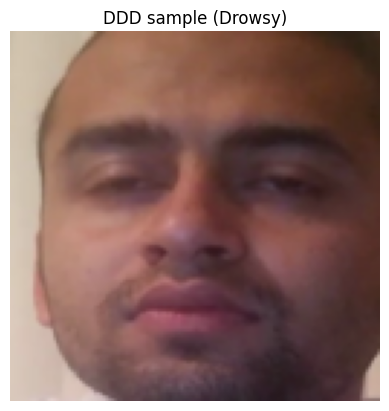

DDD sample logits: [10.204843 -7.221894]
DDD sample pred index: 0
DDD sample pred class: Drowsy


In [47]:
import matplotlib.pyplot as plt
import random
import torch
import numpy as np

# Optional: set this if you want readable class names
class_names = ["Drowsy", "Non Drowsy"]  # must match your training order

# pick a random index from the npz test set
idx = random.randint(0, input_tensor.shape[0] - 1)

sample = input_tensor[idx].unsqueeze(0)   # (1, 3, 64, 64)
true_label = int(labels_tensor[idx].item())

print("Random index:", idx)
print("True label index:", true_label)
if 0 <= true_label < len(class_names):
    print("True class name:", class_names[true_label])

# show image
img_np = sample[0].permute(1, 2, 0).cpu().numpy()
plt.imshow(img_np)
plt.axis("off")
title = "DDD sample"
if 0 <= true_label < len(class_names):
    title += f" ({class_names[true_label]})"
plt.title(title)
plt.show()

# Brevitas prediction
with torch.no_grad():
    logits_sample = brevitas_model(sample.to(device)).cpu().numpy().flatten()

pred_idx = int(logits_sample.argmax())

print("DDD sample logits:", logits_sample)
print("DDD sample pred index:", pred_idx)
if 0 <= pred_idx < len(class_names):
    print("DDD sample pred class:", class_names[pred_idx])


In [42]:
#############################################
# Test ONE sample from mnist_cnn_testset.npz
#############################################

# Choose which index from the npz you want to test
idx = 28  # change this to any index < input_tensor.shape[0]

# input_tensor[idx] has shape (1, 28, 28)
current_inp = input_tensor[idx].unsqueeze(0)  # -> (1, 1, 28, 28)

brevitas_pred = inference_with_brevitas(current_inp)
finn_pred = inference_with_finn_onnx(current_inp)

true_label = int(labels_tensor[idx].item())

print(f"Index: {idx}")
print("True label:              ", true_label)
print("Brevitas CNN prediction: ", brevitas_pred)
print("FINN-ONNX prediction:    ", finn_pred)


Index: 28
True label:               0
Brevitas CNN prediction:  0
FINN-ONNX prediction:     0


Custom image tensor shape: torch.Size([1, 3, 128, 128])
min pixel: 0.0117647061124444 max pixel: 0.9725490212440491


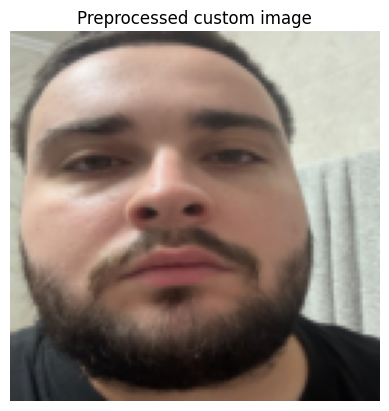

Custom image path:        dataset/tura2/non_drowsy/4.png
Raw logits:               [-0.5451573   0.77810633]
Brevitas CNN prediction:  1
FINN-ONNX prediction:     1


In [58]:
from PIL import Image
import torchvision.transforms as T

custom_image_path = "dataset/tura2/non_drowsy/4.png"   # <-- change to your file

transform_custom = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
])

img = Image.open(custom_image_path).convert("RGB")
inp = transform_custom(img).unsqueeze(0).float()   # (1, 3, 64, 64)

print("Custom image tensor shape:", inp.shape)
print("min pixel:", float(inp.min()), "max pixel:", float(inp.max()))

plt.imshow(inp[0].permute(1, 2, 0).numpy())
plt.axis("off")
plt.title("Preprocessed custom image")
plt.show()

with torch.no_grad():
    logits = brevitas_model(inp.to(device)).cpu().numpy().flatten()
brevitas_pred = int(logits.argmax())

finn_pred = inference_with_finn_onnx(inp)

print("Custom image path:       ", custom_image_path)
print("Raw logits:              ", logits)
print("Brevitas CNN prediction: ", brevitas_pred)
print("FINN-ONNX prediction:    ", finn_pred)



In [12]:
try:
    assert ok == n_verification_inputs
    print("Verification succeeded. Brevitas and FINN-ONNX execution outputs are identical")
except AssertionError:
    assert False, "Verification failed. Brevitas and FINN-ONNX execution outputs are NOT identical"

Verification succeeded. Brevitas and FINN-ONNX execution outputs are identical
